# RTKlib work
## Описание задачи
Даны rinex-файлы наблюдений gps-спутника за 2007-2012 год (около 365 файлов за каждый год).

Необходимо обработать файлы наблюдений (переведенные в формат rinex) с помощью `rtklib` в автоматическом режиме. Посмотреть, как отличаются координаты, определить параметры тектонического движения и сезонную составляющую по высоте по полученным файлым `javd.pos`

## Описание данных:
* `javd_год_дата.o` или `javd_год_дата.n` – уже переведенные из формата rinex навигационные файлы и файлы наблюдений
* `.clk_30` – 30-секундные часовые файлы орбит с сайта `cddis.nasa.gov`
* `.sp3` – файлы орбит (эфемерид) с сайта `cddis.nasa.gov`


### Для начала я написал парсер для скачивания данных (30-секундные и эфимириды) с сайта `nasa`

In [ ]:
import requests
from multiprocessing import Pool
import os.path

def pars(i):
    p=0
    for k in range(0,7):
        if os.path.exists(f'D:\\coursework\\igs{str(i)+str(k)}.clk_30s.Z') == False:
            url = "https://cddis.nasa.gov/archive/gnss/products/"+str(i)+"/igs"+str(i)+str(k)+".clk_30s.Z" # (для 30-ти секундных)
            print(url)
            response = requests.get(url)
            with open('igs' + str(i) + str(k) + '.clk.Z', 'wb') as file: 
                    file.write(response.content)
        else:
            p=p+1
            
gps_weeks = [i for i in range(1408,1513)] # нужны gnss week от 1408 до 1513

if __name__ == '__main__':
    pool = Pool(4)
    pool.map(pars, gps_weeks)


### Далее пишу скрипт для подключения к `rtklib`, а именно к `rnx2rtkp`

### И прописываю нужные параметры в settings.conf

In [ ]:
import subprocess
import os
import pathlib
import glob, os
from multiprocessing import Pool

year = str(8)
date = []
gps_week = []
os.chdir("D:\\coursework")
for file in glob.glob("*.0"+year+"o"):
    date.append(str(file)[5:13])

for file in glob.glob("*.sp3"):
    gps_week.append(str(file)[3:8])

for i in range(len(date)):
    os.rename('igs'+gps_week[i]+'.sp3','igs'+date[i]+'.sp3')
    os.rename('igs'+gps_week[i]+'.clk','igs'+date[i]+'.clk')
     

""" функция для обработки каждого набора файлов javd_(date).07o javd_(date).o7N igs(date).sp3 igs(date).clk_30s  """
def ex(date1):
    print("execute javd_" + date1)
    subprocess.call(['./rnx2rtkp -k settings.conf -o javd_'+date1+'.pos javd_'+date1+'.0'+year+'o \
    javd_'+date1+'.0'+year+'N igs'+date1+'.sp3 igs'+date1+'.clk'], shell = True)

if __name__ == '__main__':
    pool = Pool(4)
    pool.map(ex, date)

### Далее уже полученные файлы `javd_дата.pos` я анализировал и строил графики нужных величин. 
### Построил графики широты,долготы, высоты. Для первых двух - линейная ароксимация, для последнего я попробовал подобрать синусоиду, описывающую этот график

Для широты:

Коэффициент перед Days= 4.1572424568286476e-10 
Intercept= 59.942260791112304


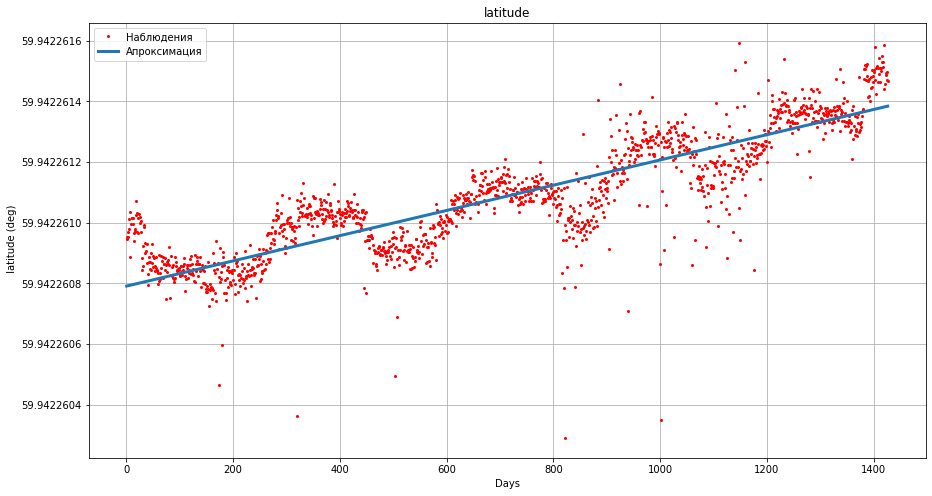

In [9]:
from matplotlib import pyplot as plt
import glob, os
from datetime import date
import pylab 
import math
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy import odr
plt.rcParams['figure.figsize'] = [15, 8]

data = []
os.chdir("D:\\RTKlib_work\\2007-2012")

for file in glob.glob("*.pos"):
    data.append(str(file)[5:13])

xdata = [0 for i in range(len(data))]

for i in range(len(data)):
    xdata[i] = date (int((data[i])[0:4]), int((data[i])[4:6]), int((data[i])[6:8]))
    

latitude = []
longitude = []
height = []


for i in range(len(data)):
    with open("D:\\RTKlib_work\\2007-2012\\javd_"+str(data[i])+".pos",'r') as file:
        for line in file:
            if "%" in line:
                continue
            latitude.append(float(line.split()[2]))
            longitude.append(float(line.split()[3]))
            height.append(float(line.split()[4]))

days = np.linspace(1,1426,1426)

def f1(B, x):
    return B[0]*x + B[1]
    
linear_model_np = odr.Model(f1)
data_to_fit_np = odr.Data(days, latitude)                              
job_np = odr.ODR(data_to_fit_np, linear_model_np, beta0=[1., 0.])
results_np = job_np.run()
a_fitted_np = results_np.beta[0]
b_fitted_np = results_np.beta[1]
y_pred_np = a_fitted_np * days + b_fitted_np
print('Коэффициент перед Days=',a_fitted_np,'\nIntercept=',b_fitted_np)

plt.title("latitude")
plt.ylabel(" latitude (deg)")
plt.xlabel("Days")
plt.grid()
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.plot(days, latitude, 'ro', markersize=2)
plt.plot(days, y_pred_np , linewidth=3)
plt.legend(['Наблюдения','Апроксимация'])
plt.show()


Для долготы 

Коэффициент перед Days= 8.546203213746515e-10 
Intercept= 30.295444449604865


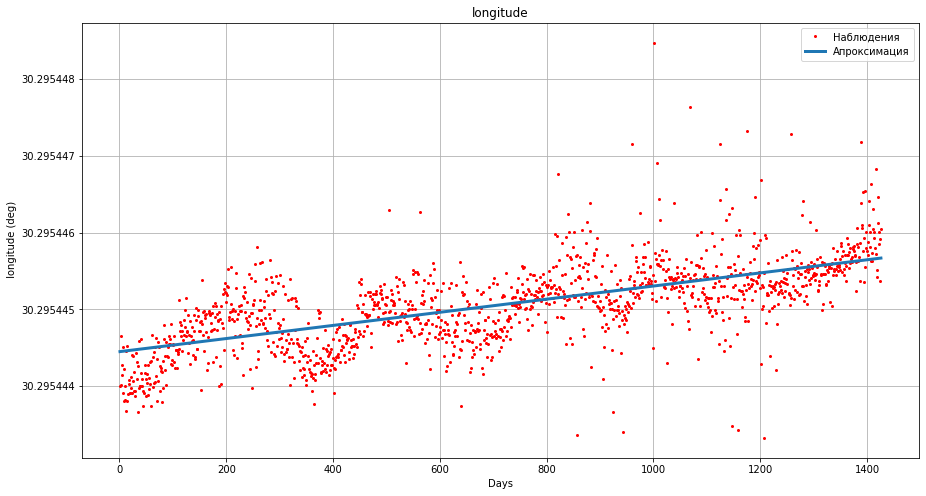

In [14]:
linear_model_np = odr.Model(f1)
data_to_fit_np = odr.Data(days, longitude)                              
job_np = odr.ODR(data_to_fit_np, linear_model_np, beta0=[1., 0.])
results_np = job_np.run()
a_fitted_np = results_np.beta[0]
b_fitted_np = results_np.beta[1]
y_pred_np = a_fitted_np * days + b_fitted_np
print('Коэффициент перед Days=',a_fitted_np,'\nIntercept=',b_fitted_np)

plt.title("longitude")
plt.ylabel(" longitude (deg)")
plt.xlabel("Days")
plt.grid()
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.plot(days, longitude, 'ro', markersize=2)
plt.plot(days, y_pred_np , linewidth=3)
plt.legend(['Наблюдения','Апроксимация'])
plt.show()


28.9096920056101


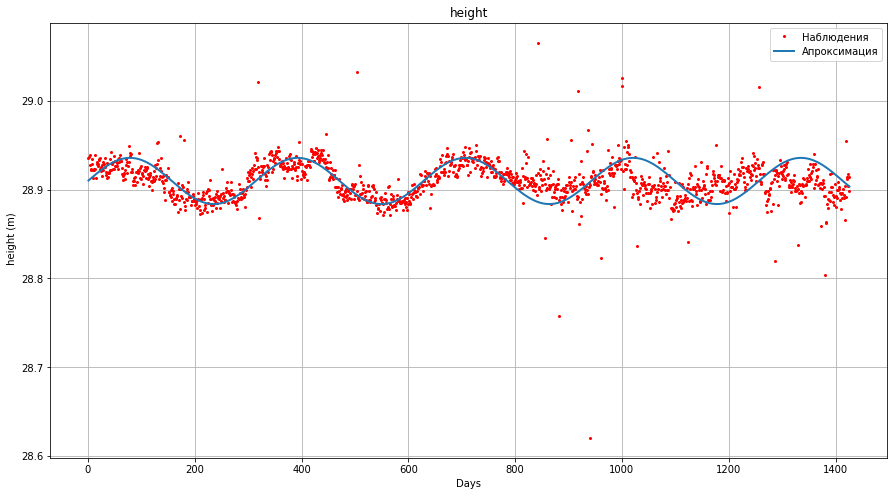

In [15]:
print(np.mean(height))
plt.title("height")
plt.ylabel(" height (m)")
plt.xlabel("Days")
plt.grid()
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.plot(days, height, 'ro', markersize = 2)
plt.plot(days, 28.9096920056101+0.026*np.sin(days/50), linewidth=2)
plt.legend(['Наблюдения','Апроксимация'])
plt.show()

### Можно заметить,что для широты и долготы присутстует возрастающий тренд и есть периодичность в год, а у графика высоты у нас только годовая периодичность 